# What is about 

Compute growth (i.e. layer sizes) and make first analysis  of Cayley graphs for consecutive and wrapped k cycles and their Schreier coset graphs .


## Observations:

    Consecutive K-cycles:
    Leading coefficient (i.e. for nˆ2) is typically 1/2X(k-1) , period 2Y(k-1), for some X,Y and Y divides X . 

    With inverses or without - leading is the same (?)

    Sometimes (only sometimes): case with inverses for full graph and binary coset 0then1 seems does not contain linear terms in "n". 

    For small cosets with when only several (fixed) unique elements in vector
    God's number - grows linearly with "n"
    (Check. See v82-83etc)

    Wrapped Consecutive with inverses Coset [0,1]ˆn/2
    period = 4(K-1), leading = 1/(16(K-1) 
    starting points:
    K = 2 at 5
    K = 3 at 9
    K = 4 at 12
    Quasi-polynoms:
    K = 4 : https://chatgpt.com/share/6935dce0-67c0-8002-ab3f-be4138a508a3
    Less efficient queries for smaller K:
    K = 2 : https://chatgpt.com/share/693484c6-8cc4-8002-b0e9-e14d41636e96
    K = 3 : https://chatgpt.com/share/693484c6-8cc4-8002-b0e9-e14d41636e96

    
## Timing and RAM

    For binary cosets e.g. half0,half1 
    we can compute in 2-3 minutes up to n=32 on GPU
    n=33 - crashes GPU RAM
    n=33 - CPU - several hours, TPU - 20-30 mins.
    n=34 - CPU - crash by 12hours limit, TPU crash by 2h limit

    For full graphs
    n = 12 GPU - 1 minute
    n = 13 CPU - >12h, TPU 40 mins


#### Responsibles

    Kudashev Sergei - Consecutive with Inverses - full graph
    Dmitry Shiltsov - Consecutive Cycles Cosets  0then1 - both Iverse/no
                      Wrapped Consecutive Cycles Cosets [0,1]ˆl  Iverse closed
    Stas Krymskii - [012]ˆl Consecutive Cycles 
    Maxim Smirnov - same with ML  ([012]ˆl Consecutive Cycles )
    Anastasia Boikova - l-Repeats Coset Consecutive with Inverses 
    Zakhar Kogan - L-Different Coset Consecutive with Inverses 
    

In [1]:
try :
    import numba
    # Use for CPU,GPU Kaggle machines:
    print('Install CayleyPy without dependencies (for Kaggle CPU,GPU):'); print()
    !pip install git+https://github.com/cayleypy/cayleypy --no-deps   
except :
    print('Install CayleyPy with dependencies (for Kaggle TPU):'); print()
    # Use for TPU kaggle machines - since no numba
    !pip install git+https://github.com/cayleypy/cayleypy
    


Install CayleyPy without dependencies (for Kaggle CPU,GPU):

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/cayleypy/cayleypy to /tmp/pip-req-build-as38u3r4
  Running command git clone --filter=blob:none -q https://github.com/cayleypy/cayleypy /tmp/pip-req-build-as38u3r4
  Resolved https://github.com/cayleypy/cayleypy to commit 6298ae1d9d63fd6a48a6bd67517aacf98633805d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import numpy as np 
import pandas as pd
torch.__version__

'2.9.1+cu128'

# Compute growth (i.e. layer sizes by BFS) -  wrapped consecutive_k_cycles Cayley graph

In [3]:
%%time 
import networkx as nx
from cayleypy import CayleyGraph, PermutationGroups
import re


/home/ec2-user/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 1.45 s, sys: 109 ms, total: 1.56 s
Wall time: 1.28 s


In [4]:
%%time


k=4; 
max_diam = 30
diams = []
dict_diams = {}
last_layers = []


dict_growth = dict()
dict_last_layer = dict()


# Graph definition:
# Part 1 -- generators:
list_options = ['Koltsov3' ]  # KKK will be substituted by "k" value
graph_name_part1 = list_options[0]
#graph_name_part1 = graph_name_part1.replace("KKK", str(k) )


# Part 2 -- Inverse closed or not:
list_options = [' Inverse Closed', '']
graph_name_part2 = list_options[0]


# Part 3 -- Coset or not:
list_options = [' Coset', '']
graph_name_part3 = list_options[0]


# Part 4 -- specify what coset:
graph_name_part4 = ''
if graph_name_part3 == ' Coset':
   # Central state is repeats of some block e.g. [0,1]ˆ(n//2)
   # graph_name_part4 = ' Binary01Repeats' # central = [0,1]*(n//2) + [0]*(n - 2*(n//2) )
   # graph_name_part4 = ' Binary01Repeats_1' # central = [0,1]*(n//2) + [1]*(n - 2*(n//2) )
   # graph_name_part4 = ' 012Repeats' # [0,1,2]*(n//3)+[0,1,2][:(n%3)]
   # graph_name_part4 = ' 011Repeats' # [0,1,1]*(n//3)+[0,1,1][:(n%3)]


   # # # Central state - like 0..01..12...23...
   # graph_name_part4 = ' Binary0then1'
   # graph_name_part4 = ' 0then1then2'
   # graph_name_part4 = ' 0then1then2then3'
   # graph_name_part4 = ' 0then1then2then3then4'


   # # Central state - like 0123..n-k,n-k,n-k (Several last - coincide)
   # graph_name_part4 = ' 2Coincide' #  (0,1,2,3...,n-2,n-2)
   # graph_name_part4 = ' 3Coincide' #  (0,1,2,3...,n-3,n-3,n-3)
   # graph_name_part4 = ' 4Coincide' #
   # graph_name_part4 = ' 5Coincide' #    
   # graph_name_part4 = ' 6Coincide' #    
  
   # # Central state - like 01XXXXXXXX, i.e. almost all coincide except
    graph_name_part4 = ' 6Different' # 0111...1111
   # graph_name_part4 = ' 3Different' # 0122...2222
   # graph_name_part4 = ' 4Different' # 01233...333 
  
graph_name = graph_name_part1+graph_name_part2+graph_name_part3+graph_name_part4
print('k=',k,'max_diam=',max_diam )
print('Graph:', graph_name )
for n in range(k+1,max_diam + 1):
# for n in [36]:


   if 'Wrapped Consecutive' in graph_name:
       defn = PermutationGroups.wrapped_k_cycles(n, k)
   elif 'Consecutive' in graph_name:
       defn = PermutationGroups.consecutive_k_cycles(n, k)
   elif 'Koltsov3' in graph_name: 
        defn = PermutationGroups.koltsov3(n, perm_type=2, k=0, d=5)
   
   else:
       print('Unknown type of generators')
       raise Exception("Unknown type of generators")
      
   if 'Inverse Closed' in graph_name:
       defn = defn.make_inverse_closed()
   if 'Coset' in graph_name:
       if 'Binary01Repeats_1' in graph_name:
           central = [0,1]*(n//2) + [1]*(n - 2*(n//2) )
       elif 'Binary01Repeats' in graph_name:
           central = [0,1]*(n//2) + [0]*(n - 2*(n//2) )
       elif 'Repeats' in graph_name:
           # Extract the repeating block:
           match = re.search(r"(\d+)(?=Repeats)", graph_name)
           lst = [int(char) for char in match.group(1)]
           len_str = len(lst)
           central = lst*(n//len_str) + lst[ :(n % len_str) ]
       elif '0then1then2then3then4' in graph_name:
           central = [0]*(n//5) +  [1]*(n//5) + [2]*(n//5) + [3]*(n//5) +  [4]*(n - 4*(n//5) )
       elif '0then1then2then3' in graph_name:
           central = [0]*(n//4) +  [1]*(n//4) + [2]*(n//4) +   [3]*(n - 4*(n//4) )
       elif '0then1then2' in graph_name:
           central = [0]*(n//3) +  [1]*(n//3) +  [2]*(n - 2*(n//3) )
       elif 'Binary0then1' in graph_name:
           central = [0]*(n//2) + [1]*(n - n//2)
       elif 'Coincide' in graph_name:
           match = re.search(r"(\d+)(?=Coincide)", graph_name)
           n_coincide = int(match.group(1))
           #print(n, n_coincide)
           central = list(range(n-n_coincide)) + [n-n_coincide]*n_coincide
       elif 'Different' in graph_name:
           match = re.search(r"(\d+)(?=Different)", graph_name)
           D = int(match.group(1))
      
           # Invalid regime — skip
           if n < D:
               continue
      
           central = list(range(D-1)) + [D-1] * (n - (D-1))


          
       print('central:', central)
       if len( np.unique( central )) == 1: continue
          
       defn = defn.with_central_state(central)
      
   graph = CayleyGraph(defn)
   result = graph.bfs(return_all_edges=False, return_all_hashes=False)
   diams.append(result.diameter())
   dict_diams[n] = result.diameter()
   last_layers.append(result.last_layer())
   print(f"n={n}, Bfs result:{result}\n")
   dict_key = graph_name+'|'+str(k)+'|'+str(n)
   dict_growth[dict_key] = result.layer_sizes
   dict_last_layer[dict_key] = result.last_layer()[:10000].tolist()

k= 4 max_diam= 30
Graph: Koltsov3 Inverse Closed Coset 6Different
central: [0, 1, 2, 3, 4, 5]
n=6, Bfs result:BfsResult(diameter=6, layer_sizes=[1, 3, 5, 7, 9, 8, 3])

central: [0, 1, 2, 3, 4, 5, 5]
n=7, Bfs result:BfsResult(diameter=20, layer_sizes=[1, 3, 5, 7, 10, 16, 26, 40, 57, 79, 114, 160, 229, 296, 352, 399, 340, 254, 108, 22, 2])

central: [0, 1, 2, 3, 4, 5, 5, 5]
n=8, Bfs result:BfsResult(diameter=17, layer_sizes=[1, 3, 5, 7, 10, 16, 26, 41, 53, 65, 86, 96, 71, 46, 28, 15, 6, 1])

central: [0, 1, 2, 3, 4, 5, 5, 5, 5]
n=9, Bfs result:BfsResult(diameter=31, layer_sizes=[1, 3, 5, 7, 10, 16, 26, 41, 61, 86, 124, 179, 252, 336, 431, 564, 733, 947, 1193, 1400, 1581, 1696, 1605, 1360, 1081, 718, 407, 176, 54, 20, 6, 1])

central: [0, 1, 2, 3, 4, 5, 5, 5, 5, 5]
n=10, Bfs result:BfsResult(diameter=22, layer_sizes=[1, 3, 5, 7, 10, 16, 26, 41, 61, 87, 122, 167, 224, 279, 298, 291, 269, 227, 142, 75, 35, 13, 1])

central: [0, 1, 2, 3, 4, 5, 5, 5, 5, 5, 5]
n=11, Bfs result:BfsResult(diamet

In [4]:
print(dict_diams)

{5: 7, 6: 6, 7: 21, 8: 19, 9: 36, 10: 26, 11: 63, 12: 43}


In [5]:
import json

id_rand = np.random.randint(1, 100000) 
# Save dictionary to JSON file
fname = "dict_growth_"+str(id_rand)+".json"
with open(fname, "w") as f:
    json.dump(dict_growth, f, indent=4)  # indent makes it readable

fname = "dict_last_layer_"+str(id_rand)+".json"
with open(fname, "w") as f:
    json.dump(dict_last_layer, f, indent=4)  # indent makes it readable

In [6]:
for ids in dict_last_layer:
    last_layer = dict_last_layer[ids]
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    print('n=',n, )
    print('last_layer:')
    print(np.array(last_layer) )

n= 5
last_layer:
[[4 1 3 2 0]
 [1 4 2 3 0]
 [2 3 1 4 0]
 [4 0 2 3 1]
 [4 2 0 1 3]
 [2 1 0 4 3]
 [1 3 2 0 4]
 [2 1 3 0 4]
 [3 0 2 1 4]
 [3 1 0 2 4]
 [1 2 0 3 4]
 [2 0 1 3 4]]
n= 6
last_layer:
[[5 4 3 2 1 0]
 [3 2 5 4 0 1]
 [4 5 1 0 3 2]]
n= 7
last_layer:
[[4 3 5 1 0 2 6]
 [0 4 2 5 1 3 6]
 [2 1 0 5 4 3 6]]
n= 8
last_layer:
[[0 2 1 3 4 5 6 7]]
n= 9
last_layer:
[[5 8 6 2 3 1 4 7 0]
 [4 3 7 0 6 8 2 5 1]
 [0 7 3 4 6 8 2 5 1]
 [8 5 3 4 6 0 2 7 1]
 [4 0 7 3 6 8 1 5 2]
 [5 4 6 0 1 2 8 7 3]
 [0 8 6 2 3 7 4 1 5]
 [3 8 6 1 0 7 4 2 5]
 [1 6 8 3 0 7 4 2 5]
 [4 7 0 6 3 1 8 2 5]
 [3 0 7 6 4 1 8 2 5]
 [0 6 4 7 1 3 2 8 5]
 [7 6 3 0 1 4 2 8 5]
 [2 5 7 4 0 8 3 1 6]
 [1 5 7 0 4 8 3 2 6]
 [3 4 5 8 1 0 2 7 6]
 [3 4 6 2 5 8 1 0 7]
 [0 4 6 5 2 8 1 3 7]]
n= 10
last_layer:
[[1 4 8 5 2 0 7 9 6 3]
 [2 3 7 6 1 0 8 9 5 4]
 [2 7 3 1 6 8 0 5 9 4]
 [1 7 0 2 6 8 3 5 9 4]
 [3 6 2 0 7 9 1 4 8 5]
 [5 0 4 9 1 3 8 6 2 7]
 [5 4 0 1 9 8 3 2 6 7]
 [6 3 0 2 9 7 4 1 5 8]
 [2 0 3 6 9 7 4 1 5 8]
 [0 2 1 7 8 6 5 3 4 9]]
n= 11
last_l

# Plot diameters 

Fit full data:
coefs: nˆ2 , n, nˆ0 [ -0.03145671   5.51782609 -23.09314753]
coefs inverse: nˆ2 , n, nˆ0 -31.789722386296404 0.18123079347569132 -0.04330288882244783
Fit on last 50 of data:
coefs: nˆ2 , n, nˆ0 [ -0.15609391  11.17657343 -84.3538961 ]
coefs inverse: nˆ2 , n, nˆ0 -6.406400000000364 0.08947286094165856 -0.01185481698164123


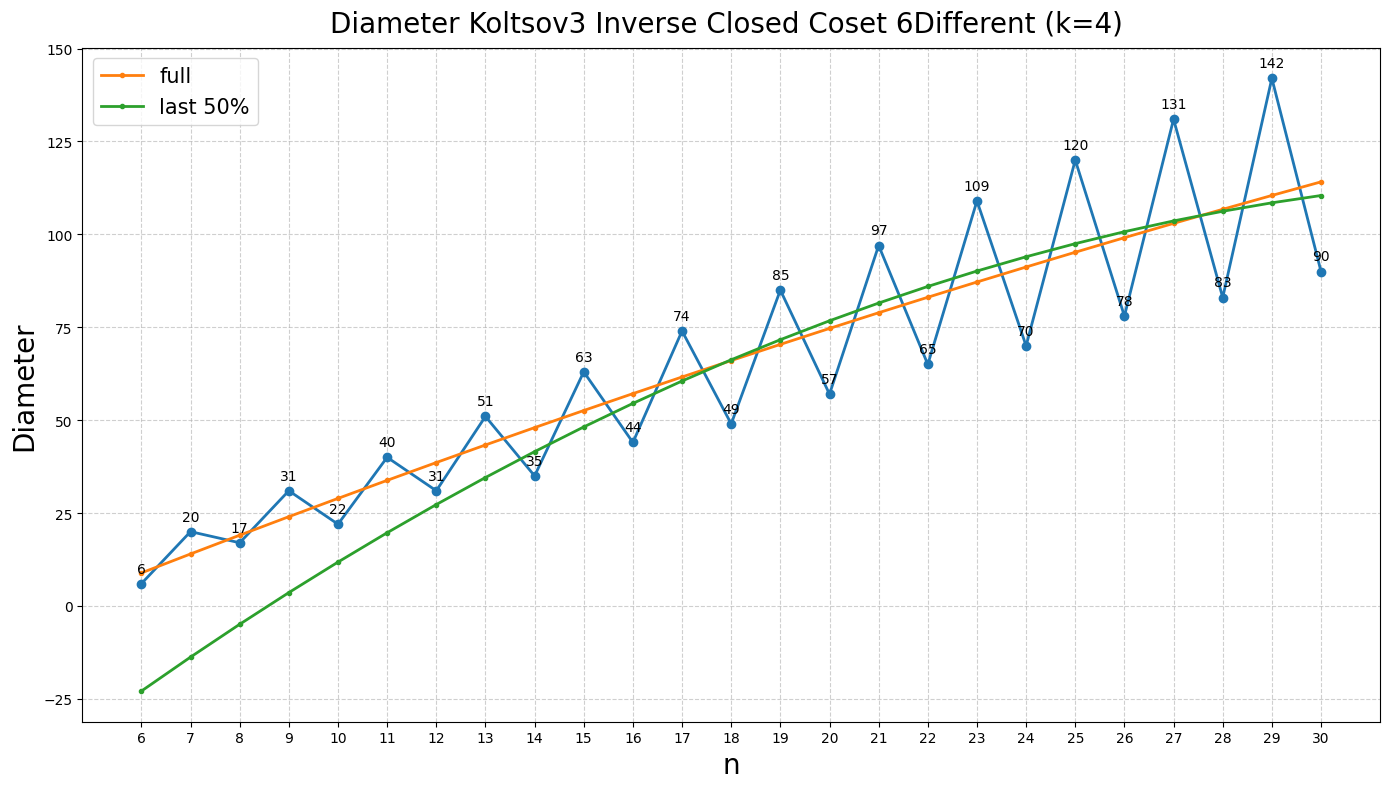

/tmp/ipykernel_845439/280227583.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = 15)


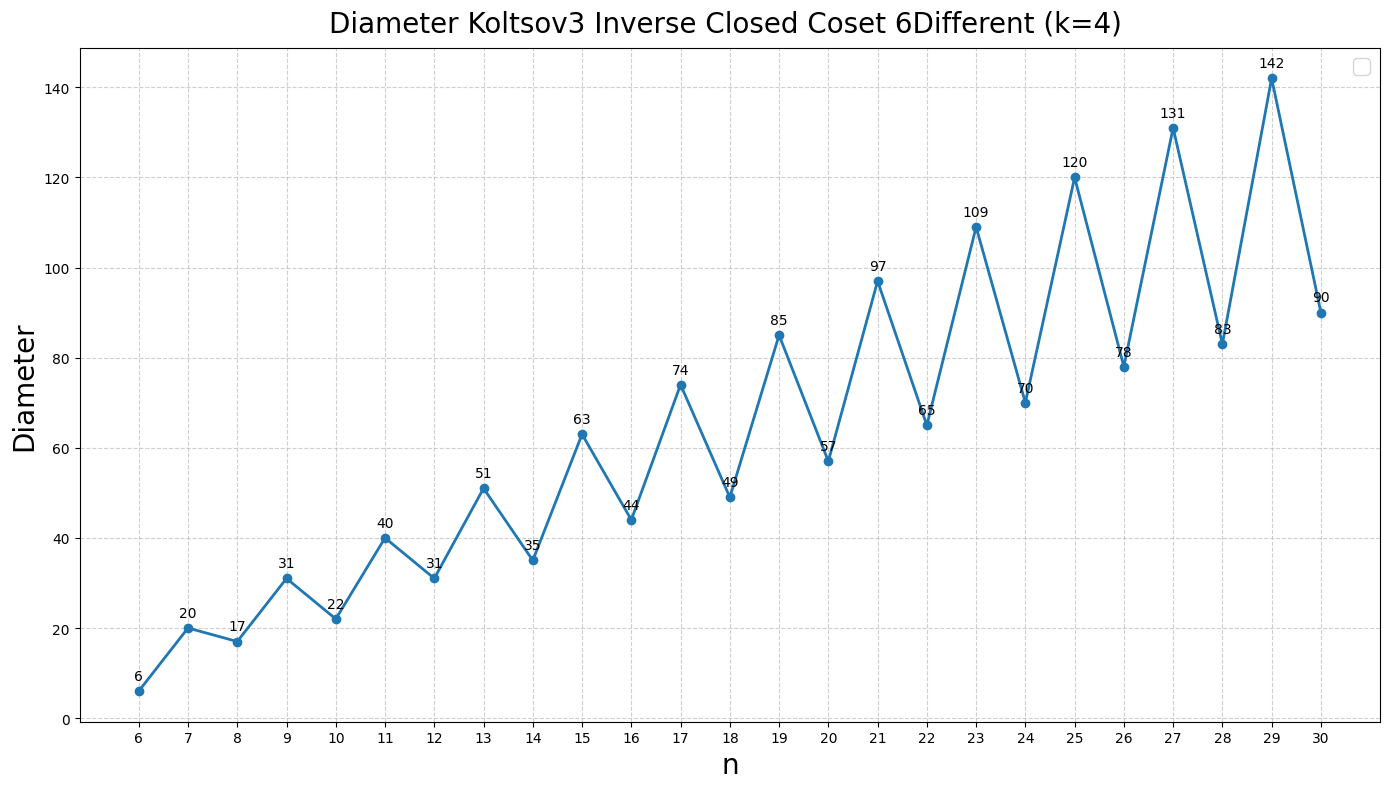

In [5]:
import matplotlib.pyplot as plt

start_n = k+1
ns = list( dict_diams.keys() )
diams_loc = list( dict_diams.values() )

# y_approx1 = np.array(ns)**2/(4*(k-1))
# y_approx2 = np.array(ns)**2/(2*(k-1))

pol = np.polyfit(ns, diams_loc, 2)
print('Fit full data:')
print('coefs: nˆ2 , n, nˆ0', pol)
print('coefs inverse: nˆ2 , n, nˆ0', 1/pol[0],1/pol[1],1/pol[2])
y_approx3 = np.polyval(pol, ns)

percent_fit = 50
print(f'Fit on last {percent_fit} of data:')
ss = int(len(ns)*percent_fit/100)
pol = np.polyfit(ns[-ss:], diams_loc[-ss:], 2)
print('coefs: nˆ2 , n, nˆ0', pol)
print('coefs inverse: nˆ2 , n, nˆ0', 1/pol[0],1/pol[1],1/pol[2])
y_approx4 = np.polyval(pol, ns)

for tmp in [0,1]: # Repeat plot twice - with approximation and without
    
    plt.figure(figsize=(14,8))
    plt.plot(ns, diams_loc, marker='o', linewidth=2)

    if tmp == 0:
        # plt.plot(ns, y_approx1, marker='.', linewidth=2)
        # plt.plot(ns, y_approx2, marker='.', linewidth=2)
        plt.plot(ns, y_approx3, marker='.', linewidth=2, label = 'full')
        plt.plot(ns, y_approx4, marker='.', linewidth=2, label = 'last '+str(percent_fit) +'%')
    
    plt.title(f"Diameter {graph_name} (k={k}) ", fontsize=20, pad=12)
    plt.xlabel("n", fontsize=20)
    plt.ylabel("Diameter", fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize = 15)
    plt.xticks(ns)
    
    for x, y in zip(ns, diams_loc):
        plt.annotate(str(y), (x, y), textcoords="offset points", xytext=(0, 8), ha="center", fontsize=10)
    
    plt.tight_layout()
    plt.show()


In [30]:
diams

[19, 36, 26, 50, 36, 66, 44, 82, 54, 96, 64, 111, 74, 128, 84, 144, 95]

# Plot growths

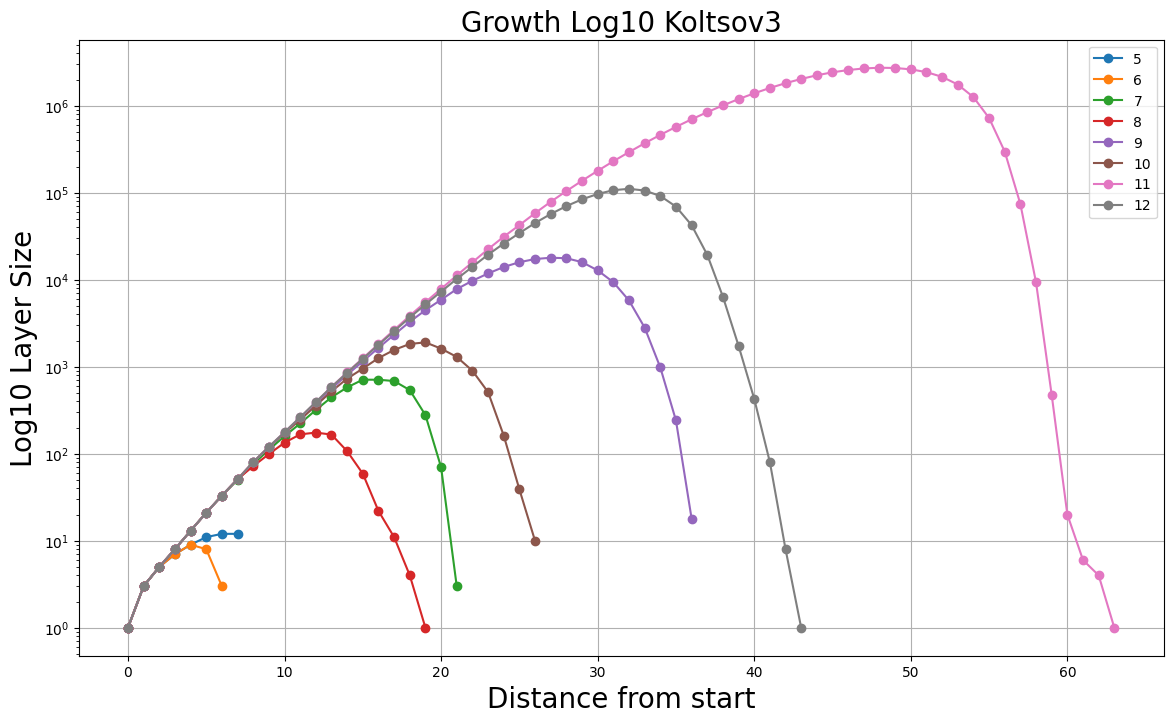

In [9]:
plt.figure(figsize=(14, 8))

for ids in dict_growth:
    vec_growth = dict_growth[ids]
    
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    plt.semilogy(vec_growth,'o-', label = n )

str_inf = "Growth Log10 "+gname
plt.title(str_inf , fontsize=20)
plt.xlabel('Distance from start', fontsize=20)
plt.ylabel('Log10 Layer Size', fontsize=20)
plt.legend()
plt.grid()
plt.show()

    

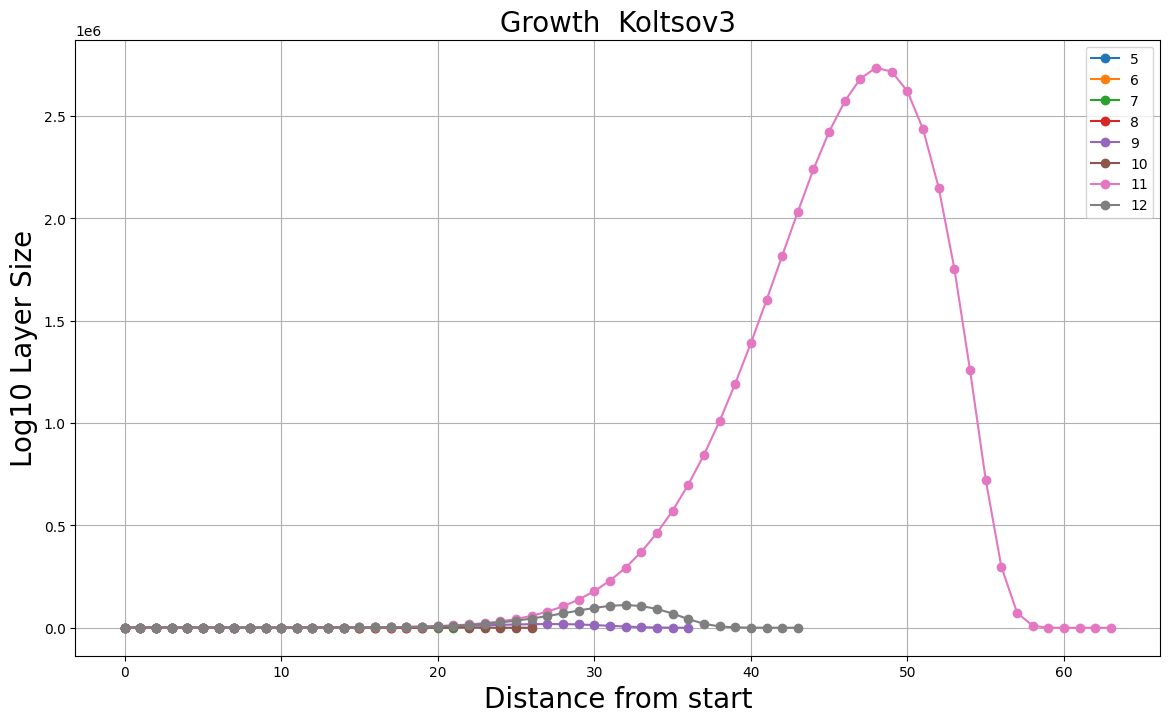

In [10]:
plt.figure(figsize=(14, 8))

for ids in dict_growth:
    vec_growth = dict_growth[ids]
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    plt.plot(vec_growth,'o-', label = n )

str_inf = "Growth  "+ gname
plt.title(str_inf , fontsize=20)
plt.xlabel('Distance from start', fontsize=20)
plt.ylabel('Log10 Layer Size', fontsize=20)
plt.legend()
plt.grid()
plt.show()

# Plot Last layers sizes 

/tmp/ipykernel_7101/1774795513.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


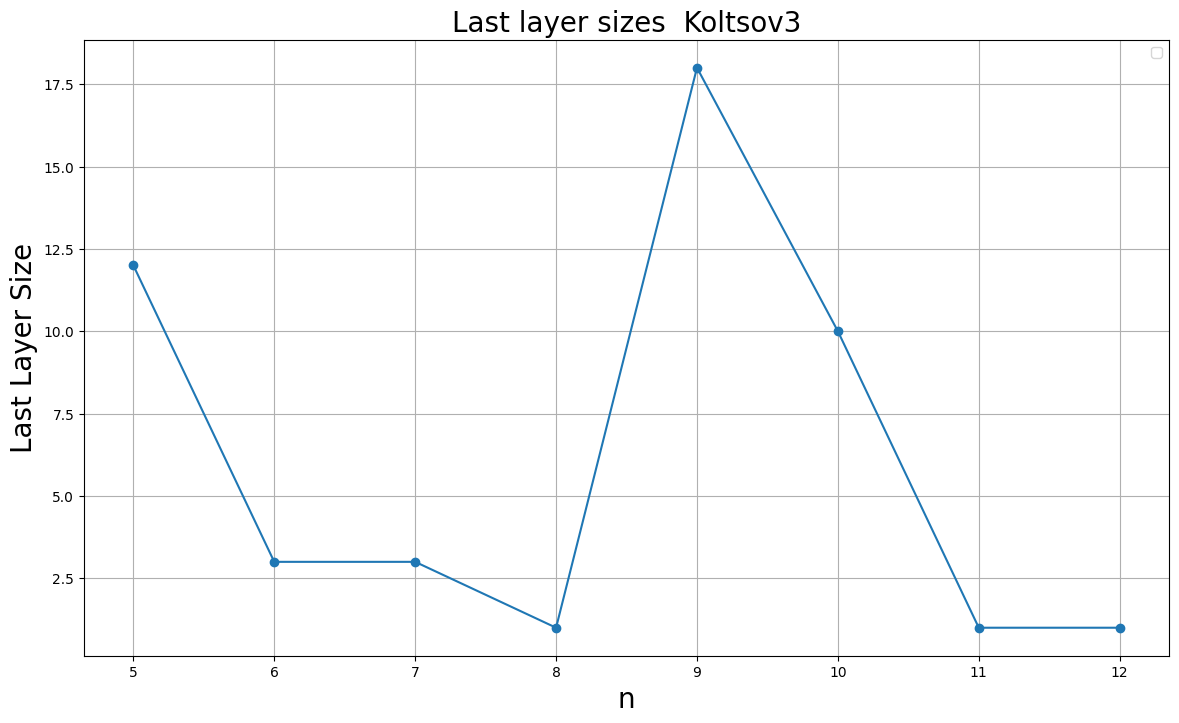

,last layer size
n,
5,12
6,3
7,3
8,1
9,18
10,10
11,1
12,1


[12, 3, 3, 1, 18, 10, 1, 1]


In [11]:
plt.figure(figsize=(14, 8))

x = []
y = []
for ids in dict_last_layer:
    last_layer = dict_last_layer[ids]
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    x.append(n)
    y.append(len(last_layer))
plt.plot(x,y,'o-'  )

str_inf = "Last layer sizes  "+ gname
plt.title(str_inf , fontsize=20)
plt.xlabel('n', fontsize=20)
plt.ylabel('Last Layer Size', fontsize=20)
plt.legend()
plt.grid()
plt.show()
df1 = pd.DataFrame()
df1['n'] = x 
df1 = df1.set_index('n')
df1['last layer size'] = y 
display(df1)
df1.to_csv('last_layer_sizes.csv')
print(y)